# Results and Analysis

In [24]:
import pandas as pd
import os
import sys
import keras
import pathlib
import itertools

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from src.neural_backend.load_data import load_data
from src.neural_backend.load_embeddings import load_embeddings, load_afinn_matrix
from src.neural_backend.preprocessor import create_polarity_dict
from src.neural_backend.util import get_save_path
from src.neural_backend.metrics import f1, precision, recall

from keras.layers import Input, Dense, Bidirectional, Dropout, LSTM, Embedding, SpatialDropout1D, GaussianNoise
from keras.regularizers import l2
from keras.optimizers import RMSprop
from keras.models import Model
from src.neural_backend.layers.Attention import FeedForwardAttention as Attention

plt.rcParams["figure.facecolor"] = 'w'
plt.rcParams["axes.facecolor"] = 'w'
plt.rcParams['axes.facecolor'] = 'w'

In [2]:
def get_save_path(model_name='BiLSTMAttention', directory='./model_checkpoints', fold=None):
    path = directory + '/{}/{}'.format(model_name, model_name)
    # create dirs if they don't exist.
    pathlib.Path(directory + '/{}/'.format(model_name)).mkdir(parents=True, exist_ok=True)

    if fold is not None:
        path = path + '-fold-{}'.format(fold)

    path = path + '.hdf5'

    return path

In [3]:
# Paths to glove embeddings.
glove_path = '../data/embeddings/glove.twitter.27B.200d.txt'
embed_dims = 200
embed_type = 'GLOVE'
MAX_FEATS = 150000
sem_eval_path = '../data/sem_eval/full/'
BATCH_SIZE = 128
EPOCHS = 50
LEARN_RATE = 0.001
CLIP_NORM = 5.0
NUM_CLASSES = 12
RNN_UNITS = 150
L2_REG = 0.0001

In [4]:
(x_train, y_train), (x_val, y_val), word_index, num_classes, lb = load_data(path=sem_eval_path,
                                                           data_set='sem_eval',
                                                           max_features=MAX_FEATS)
embedding_matrix = load_embeddings(path=glove_path,
                                   embedding_type=embed_type,
                                   word_index=word_index,
                                   max_features=MAX_FEATS,
                                   embedding_dimensions=embed_dims)

neutral     22211
positive    19625
negative     7732
Name: class, dtype: int64


49568it [00:29, 1696.05it/s]


Number of Data Samples:49568
Loading GLOVE embeddings...
Reading GLOVE file...


1193514it [01:14, 16031.72it/s]


Generating embedding matrix...


100%|████████████████████████████████████████████████████████████████████████| 40693/40693 [00:00<00:00, 350796.87it/s]


40694 Unique words (vocab size).
5954 Unique OOV words.


In [5]:
vocab_size = len(word_index) + 1
input_length = x_train.shape[1]
embed_dim = embed_dims

In [6]:
rnn_input = Input(shape=(input_length,))

embedding = Embedding(vocab_size,
                              embed_dim,
                              weights=[embedding_matrix],
                              input_length=input_length,
                              name="embedding")(rnn_input)

spatial_dropout_1 = SpatialDropout1D(0.3, name="spatial_dropout")(embedding)

noise = GaussianNoise(0.2, name="noise")(spatial_dropout_1)

bi_gru_1 = Bidirectional(LSTM(RNN_UNITS,
                                           return_sequences=True,
                                           recurrent_regularizer=l2(L2_REG),
                                           kernel_regularizer=l2(L2_REG),
                                           name="bi_gru_1"))(noise)

bi_gru_1 = Dropout(0.3, name="bi_gru_1_dropout")(bi_gru_1)

bi_gru_2 = Bidirectional(LSTM(RNN_UNITS,
                                           return_sequences=True,
                                           recurrent_regularizer=l2(L2_REG),
                                           kernel_regularizer=l2(L2_REG),
                                           name="bi_gru_2"))(bi_gru_1)

bi_gru_2 = Dropout(0.3, name="bi_gru_2_dropout")(bi_gru_2)

attention = Attention()(bi_gru_2)

drop_1 = Dropout(0.5, name="attention_dropout")(attention)

outputs = Dense(num_classes, activation='softmax', name="output")(drop_1)

model = Model(inputs=rnn_input, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=LEARN_RATE, clipnorm=CLIP_NORM), metrics=[precision, recall, f1])

In [7]:
model.load_weights('../model_checkpoints/BiLSTMAttention/BiLSTMAttention.hdf5')

In [22]:
train_predictions = model.predict(x=x_train)
val_predictions = model.predict(x=x_val)

In [23]:
train_classes = lb.inverse_transform(train_predictions)
val_classes = lb.inverse_transform(val_predictions)
confidence = val_predictions.argmax(axis=-1)
print(val_predictions[0])
print(classes[0])
print(val_predictions[0][confidence[0]])

[0.07 0.46 0.47]
positive
0.4717965


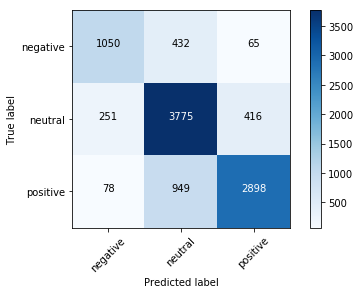

In [28]:
t_pred = train_classes
t_true = lb.inverse_transform(y_train)

y_pred = val_classes
y_true = lb.inverse_transform(y_val)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=lb.classes_,
                      title='')


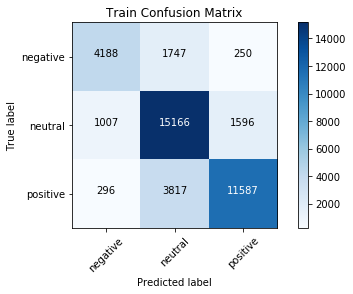

In [27]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(t_true, t_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=lb.classes_,
                      title='')